In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('cleaned_df.csv')
# drop unnamed column
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
#replace label to binary 0 and 1
data = data.replace(1, 0) 
data = data.replace(2, 1)

In [3]:
X = data.loc[:, ~data.columns.isin(['Name', 'Label'])]
y = data['Label']

In [4]:
# split and standardise
def split_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = split_datasets(X, y)

In [6]:
gbc_tuned = GradientBoostingClassifier(learning_rate = 0.7, 
                                        max_depth = 2, 
                                        n_estimators = 40)
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=2, n_estimators=40)

In [7]:
xgbc_tuned = xgb.XGBClassifier(objective="binary:logistic",
                                learning_rate=0.6,
                                n_estimators=8,
                                max_depth=4)
xgbc_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=8, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
lgr_tuned = LogisticRegression(C = 100, penalty = 'l1', solver = 'liblinear')
lgr_tuned = lgr_tuned.fit(X_train, y_train)

In [9]:
rfc_tuned = RandomForestClassifier(bootstrap=True,
                                    max_depth=40, 
                                    max_features=2,
                                    min_samples_leaf=4,
                                    min_samples_split=4,
                                    n_estimators=5)

rfc_tuned = rfc_tuned.fit(X_train, y_train)

In [10]:
dtc_tuned = DecisionTreeClassifier(criterion='log_loss',
                                    splitter='random',
                                    max_depth=8)
dtc_tuned = dtc_tuned.fit(X_train, y_train)

#### Confusion Matrix

In [11]:
def plot_cross_val_confusion_matrix(clf, X, y, display_labels='', title='', cv=5):
    '''
    Function to plot confusion matrix given the result of cross-validation, as oposed to the standard confucion matriax on test split data.
    
    Parameters
    ----------
    clf : estimator object implementing 'fit' and 'predict'
        The object to use to fit the data.
    X : array-like
        The data to fit. Can be, for example a list, or an array at least 2d..
    y : array-like
        The target variable to try to predict in the case of
    supervised learning.
    display_labels : ndarray of shape (n_classes,), optional
        display labels for plot. The default is ''.
    title : string, optional
        Title to be displayed at top of plot. The default is ''.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.. The default is 5.
    Returns
    -------
    display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
    '''
    
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    cm_norm = confusion_matrix(y, y_pred, normalize='true')
    fig = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=display_labels)
    fig.plot(cmap=plt.cm.Blues)
    fig.ax_.set_title(title)
    
    return fig

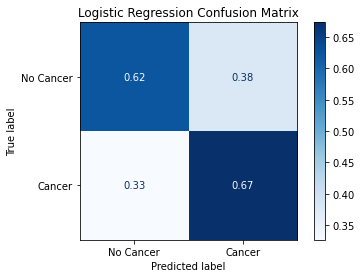

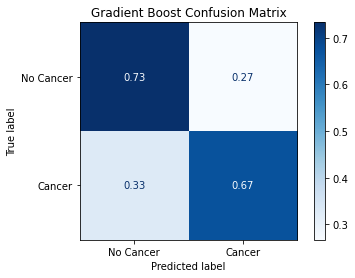

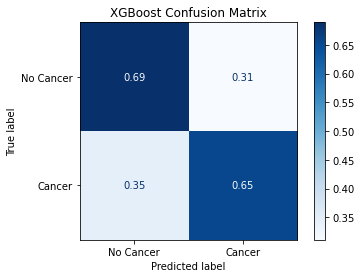

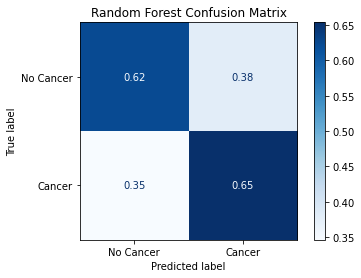

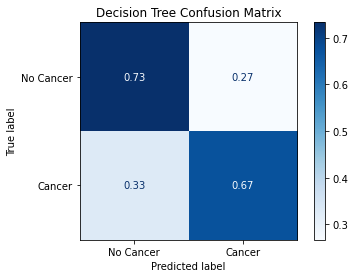

In [12]:
#np.random.seed(2)
skf = StratifiedKFold(n_splits=5, shuffle=True)

plot_cross_val_confusion_matrix(lgr_tuned, X, y, 
                                display_labels=('No Cancer', 'Cancer'), 
                                title='Logistic Regression Confusion Matrix', 
                                cv=skf)

plot_cross_val_confusion_matrix(gbc_tuned, X, y, 
                                display_labels=('No Cancer', 'Cancer'), 
                                title='Gradient Boost Confusion Matrix', 
                                cv=skf)

plot_cross_val_confusion_matrix(xgbc_tuned, X, y, 
                                display_labels=('No Cancer', 'Cancer'), 
                                title='XGBoost Confusion Matrix', 
                                cv=skf)

plot_cross_val_confusion_matrix(rfc_tuned, X, y, 
                                display_labels=('No Cancer', 'Cancer'), 
                                title='Random Forest Confusion Matrix', 
                                cv=skf)

plot_cross_val_confusion_matrix(dtc_tuned, X, y, 
                                display_labels=('No Cancer', 'Cancer'), 
                                title='Decision Tree Confusion Matrix', 
                                cv=skf)

In [19]:
def plot_learn_times(estimator, title, X, y, axes=None, ylim=None, cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross-validation,
        - integer, to specify the number of folds.
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ceri/miniconda3/envs/myenv/lib/python3.8/sit

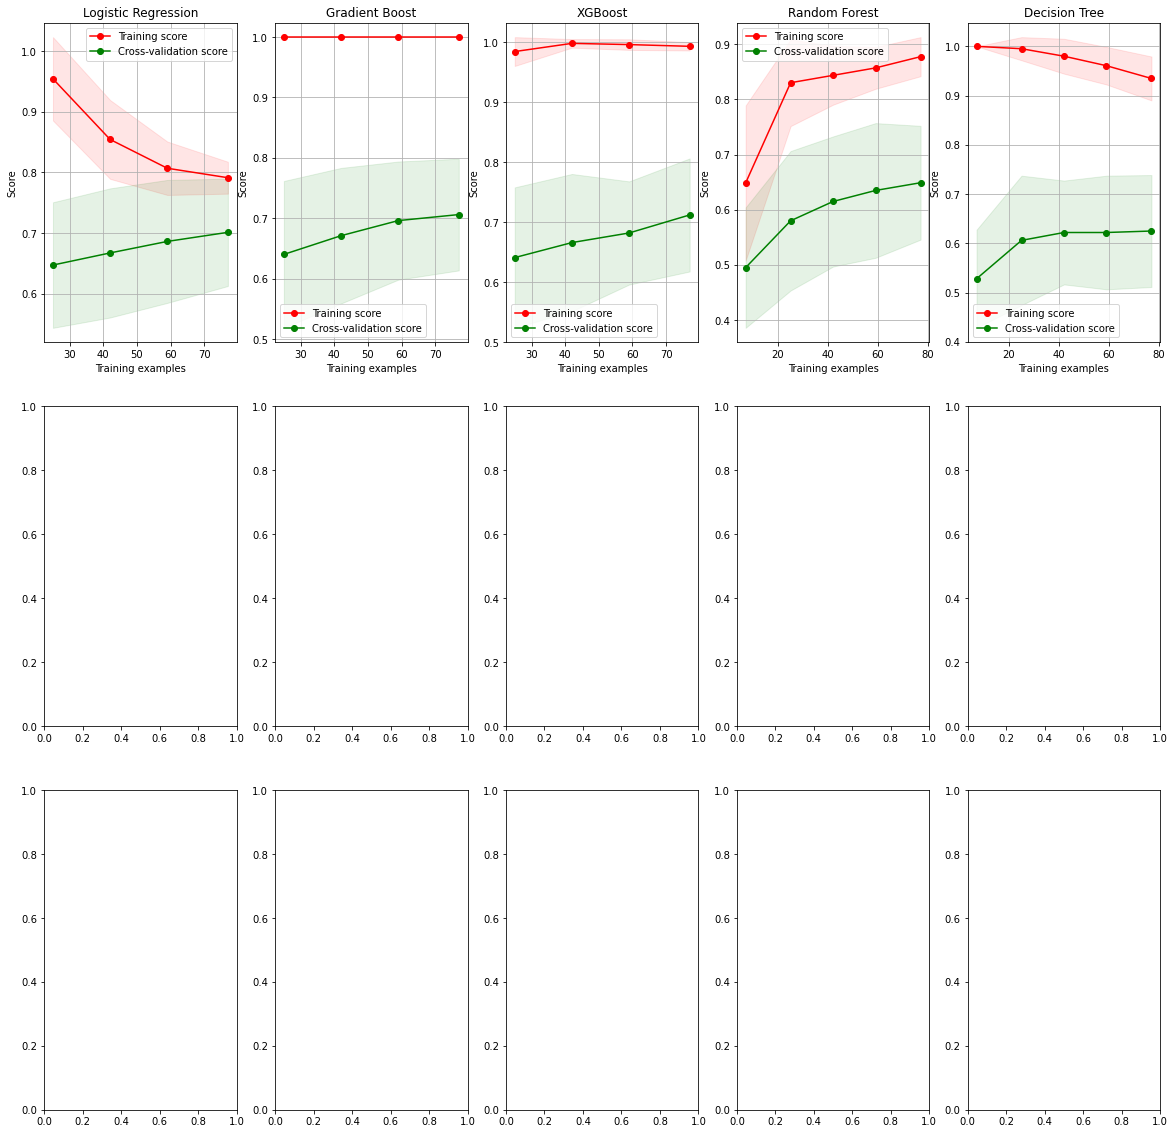

In [20]:
from sklearn.model_selection import ShuffleSplit

np.random.seed(2)

fig, axes = plt.subplots(3, 5, figsize=(20, 20))

cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

plot_learn_times(lgr_tuned, 
                'Logistic Regression', 
                X,
                y, 
                axes=axes[:, 0],
                cv=cv,
                n_jobs=4
                )

plot_learn_times(gbc_tuned, 
                'Gradient Boost', 
                X,
                y, 
                axes=axes[:, 1],
                cv=cv,
                n_jobs=4
                )

plot_learn_times(xgbc_tuned, 
                'XGBoost', 
                X,
                y, 
                axes=axes[:, 2],
                cv=cv,
                n_jobs=4
                )

plot_learn_times(rfc_tuned, 
                'Random Forest', 
                X,
                y, 
                axes=axes[:, 3],
                cv=cv,
                n_jobs=4
                )

plot_learn_times(dtc_tuned, 
                'Decision Tree', 
                X,
                y, 
                axes=axes[:, 4],
                cv=cv,
                n_jobs=4
                )

plt.show()

### ROC-AUC curves

In [15]:
#np.random.seed(2)

from sklearn.metrics import roc_auc_score

def compare_roc_auc_score(models):
    
    for model in models:
        score = roc_auc_score(y_test, model[1].predict_proba(X_test)[:, 1])
        print(
            f"{model[0]}: "
            f"AUC: {score}"
            )
    return

np.random.seed(2)

models = [
    ('lgr', lgr_tuned),
    ('rfc', rfc_tuned),
    ('dtc', dtc_tuned),
    ('gbc', gbc_tuned),
    ('xgb', xgbc_tuned)
    ]

compare_roc_auc_score(models)

lgr: AUC: 0.7647058823529411
rfc: AUC: 0.6968325791855203
dtc: AUC: 0.5950226244343892
gbc: AUC: 0.7420814479638009
xgb: AUC: 0.8144796380090498


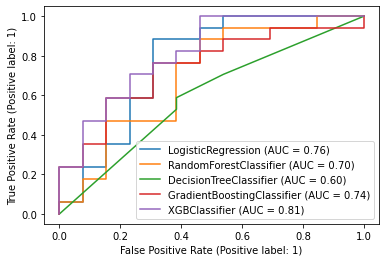

In [16]:
from sklearn.metrics import RocCurveDisplay

ax = plt.gca()
for model in models:
    RocCurveDisplay.from_estimator(model[1], X_test, y_test, ax=ax)

Model evaluation conclusions:

1. Model learning curves show ensemble models Gradient Boost, XGBoost and Decision tree are overfitting on the training set.

